In [3]:
# First, the generic imports.
import sys, os, glob, uuid, pathlib
import numpy as np
import h5py as h5
import pandas as pd
import ROOT as rt # Mostly useful here for plotting
import matplotlib.pyplot as plt # Alternative plotting option
import uproot as ur
import awkward as ak
import subprocess as sub
from numba import jit
import argparse as ap # useful when converting to script

# Next, import our utilities. We define our "path_prefix" from where we can find them.
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)

from util import ml_util as mu # Data preparation and wrangling for our neural networks.
from util import qol_util as qu # Quality-of-life stuff, like plot styles and progress bars.
from util import jet_util as ju # Jet-specific utilities, e.g. wrapping for FastJet & introducing our ML outputs to jet clustering.
from util import io_util as iu # Utilities for scaling regression input/output.

# Classification-specific utilities (network setup).
from util.classification import data_util as cdu
from util.classification import training_util as ctu # besides training, can be used to load network from file
import util.classification.models as classifier_models
import util.classification.models_exp as classifier_models_exp

# Regression-specific utilities (data-loading, network setup).
from util.regression import data_util as rdu
from util.regression import training_util as rtu # besides training, can be used to load network from file
import util.regression.models as regressor_models

Welcome to JupyROOT 6.24/02


2021-07-25 03:27:58.379705: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# ML4P for Jet Clustering

In this notebook, we'll use our topo-cluster classifiers and regressors to correct the energies of topo-clusters, and then cluster these topo-clusters into jets! The goal is to see how using these corrected energies (i.e. applying our ML stuff) affects the jet energy scale resolution.

## Setup

First we have to import a whole bunch of things we'll use.

In [1]:
# # For quickly testing when working on external libraries
# %load_ext autoreload
# %autoreload 2

In [56]:
# def main(args):
    
#     parser = ap.ArgumentParser()
#     parser.add_argument(
#         '-c',
#         type=float,
#         help='Classification score cut.',
#         default = 0.5
#     )
    
#     args = parser.parse_args()
#     classification_score_cut = args.c

classification_score_cut = 0.5
score_cut_string = '{:.2f}'.format(classification_score_cut).replace('.','')

In [4]:
# Set up some plotting stuff.
plot_style = 'dark'
ps = qu.PlotStyle(plot_style)
ps.SetStyle() # will automatically affect ROOT plots from here on out, it sets ROOT.gStyle.
rt.gStyle.SetOptStat(0)

In [5]:
# Set up some calorimeter metadata.
# TODO: Get this from one of our libraries
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

In [6]:
# Perform fastjet setup. This function will download & build fastjet if it isn't found at the given location.
fastjet_dir = path_prefix + 'fastjet'
fastjet_dir =  ju.BuildFastjet(fastjet_dir, j=8)
fastjet_dir = glob.glob('{}/**/site-packages'.format(fastjet_dir),recursive=True)[0]
if(fastjet_dir not in sys.path): sys.path.append(fastjet_dir)
import fastjet as fj
fj.ClusterSequence.print_banner() # Get the Fastjet banner out of the way

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


## Data preparation

Let's also fetch our jet data. This is MC dijet data, so we have some light-quark jets to work with. The data contains information on topo-clusters for each event -- the same cell-level and cluster-level info we have with our network training data.

We *also* need to fetch the locations of our classification and energy regression networks, so that we can load and apply them to the data.

In [7]:
h5_name_suffix = 'jdata' # used for HDF5 files containing selected events

# We package things as a dictionary for now, since that's what our `setupPionData` function expects.
data_dir = path_prefix + 'data/jet'
rootfiles = {'jet':glob.glob(data_dir + '/*.root')}
branches = [
            'clusterE', 'clusterECalib', 
            'clusterPt', 'clusterEta', 'clusterPhi', 
            #'cluster_nCells', 'cluster_sumCellE', 
            'cluster_ENG_CALIB_TOT'#, 'cluster_EM_PROBABILITY'
] 

In [8]:
# Prepare data
h5_name = '/'.join((data_dir,h5_name_suffix))

cluster_max_eta = 0.7
cluster_min_eng_calib_tot = 0.2 # unused

pdata,pcells,sel_indices = mu.setupPionData(rootfiles,
                                            branches=branches,
                                            layers=layers,
                                            balance_data=False,
                                            verbose=True,
                                            load=True,
                                            save=True,
                                            filename=h5_name,
                                            cut_distributions=['clusterEta'],
                                            cut_values = [(-cluster_max_eta,cluster_max_eta)],
                                            cut_types=['window'],
                                            return_indices=True
                                           )

# Get rid of one layers of keys, which is redundant in this case.
pdata = pdata['jet']
pcells = pcells['jet']
sel_indices = sel_indices['jet']

Loading pandas DataFrame and calo images from /local/home/jano/ml4pions/LCStudies/jets/../data/jet/jdata_frame.h5 and /local/home/jano/ml4pions/LCStudies/jets/../data/jet/jdata_images.h5.


We also want to fetch information on EM and LC jets. These are stored in trees called `EventTree` in our files.

In [9]:
reference_jet_names = ['AntiKt4EMTopoJets','AntiKt4LCTopoJets','AntiKt4TruthJets']
jet_component_names = ['Pt','Eta','Phi','E']
jet_branches = [x+y for x in reference_jet_names for y in jet_component_names]

jet_info = ur.lazy([':'.join((x,'EventTree')) for x in rootfiles['jet']],filter_branch=lambda x: x.name in jet_branches)

### Network Preparation

Besides loading the jet data, we also need to load our models (neural networks), which we will apply to the data in order to get the corrected topo-cluster energies.

We have a number of different classifiers and regressors available -- here we will choose which ones we use. Note that our choice of classifier/regressor may also affect *how* we have to load the data. So if we switch models, we may also have to change our data-loading code.

Also note that for the energy regression, we are using a *binned* regression -- thus we will have multiple regressors for both charged and neutral pions, each corresponding to a particular range of topo-cluster reco energies.

In [10]:
classification_dir = path_prefix + 'classifier/Models/pion3'
classifier_modelname = 'cnn_split_EMB'
classifier_file = classification_dir + '/cnn/{}.h5'.format(classifier_modelname)
classifier_model = classifier_models_exp.exp_merged_model

In [11]:
regression_dir = path_prefix + 'regression_binned/Models/split_3'
regressor_modelname = 'split_emb_cnn'
regressor_model = regressor_models.split_emb_cnn

reco_energy_bin_edges = [0.,1.,10.] # lower bin edges

regression_files = {
    'charged': glob.glob(regression_dir + '/*/{a}/{a}_charged.h5'.format(a=regressor_modelname)),
    'neutral': glob.glob(regression_dir + '/*/{a}/{a}_neutral.h5'.format(a=regressor_modelname))
}

scaler_files = glob.glob(regression_dir + '/*/scalers.save')
scaler_files.sort()

for key,val in regression_files.items():
    regression_files[key].sort()

In [12]:
# Now we explicitly check that the filenames are lined up, i.e. that we will pair up the right scalers with the regression files.
for i,scaler_file in enumerate(scaler_files):
    bin_name = scaler_file.replace(regression_dir + '/','').split('/')[0]    
    for key,val in regression_files.items():
        bin_name_2 = val[i].replace(regression_dir + '/','').split('/')[0]
        assert(bin_name == bin_name_2)
        
# Also make sure that we have the right number of reco bin edges
for key,val in regression_files.items():
    assert(len(val) == len(reco_energy_bin_edges))

Now we must define our regression variables -- our energy regression will need some inputs that undergo some scaling, which is some mapping (a function) followed by application of some scalers (which were derived using training data).

In [13]:
m = 1.
b = 1.0e-5
EnergyMapping = iu.LogMapping(b=b,m=m)

In [14]:
# Some regression vars.
pdata['logE'] = EnergyMapping.Forward(pdata['clusterE'].to_numpy()) # log of reco energy, possible network input
pdata['clusterEtaAbs'] = np.abs(pdata['clusterEta'].to_numpy()) # absolute value of eta, possible network input

In [15]:
#TODO: We have scalers derived from charged pion and neutral pion data. We're just using the charged pion ones -- does this make sense?
scalers = []
scaler_branches = ['logE', 'clusterEtaAbs']
scaled_variable_prefixes = ['s{}'.format(i) for i in range(len(scaler_files))]
for i,scaler_file in enumerate(scaler_files):
    scalers.append(mu.setupScalers({'pp':pdata}, scaler_branches, scaler_file, scaled_variable_prefixes[i]))

Loading scalers from /local/home/jano/ml4pions/LCStudies/jets/../regression_binned/Models/split_3/e0/scalers.save.
Loading scalers from /local/home/jano/ml4pions/LCStudies/jets/../regression_binned/Models/split_3/e1/scalers.save.
Loading scalers from /local/home/jano/ml4pions/LCStudies/jets/../regression_binned/Models/split_3/e2/scalers.save.


Let's load the actual networks now.

In [16]:
classifier, _ = ctu.TrainNetwork(classifier_model(), classifier_file, overwriteModel=False, finishTraining=False)

Successfully loaded model at /local/home/jano/ml4pions/LCStudies/jets/../classifier/Models/pion3/cnn/cnn_split_EMB.h5


2021-07-25 03:28:35.748874: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-25 03:28:35.840985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: Quadro P5000 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 269.00GiB/s
2021-07-25 03:28:35.841057: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-25 03:28:35.845498: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-25 03:28:35.845634: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-25 03:28:35.846882: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10


In [17]:
regressor = {}

for key,val in regression_files.items():
    regressor[key] = []
    for regressor_file in val:
        reg, _ = rtu.TrainNetwork(regressor_model(), regressor_file, overwriteModel=False, finishTraining=False)
        regressor[key].append(reg)

Since we are using multiple regressors binned by reco energy, let's fetch the indices of events that will be passed to each regressor.

In [18]:
regressor_indices = []

for i in range(len(reco_energy_bin_edges)-1,-1,-1):
    
    indices = pdata['clusterE'].to_numpy() > reco_energy_bin_edges[i]

    if(i != len(reco_energy_bin_edges)-1):
        indices *= pdata['clusterE'].to_numpy() < reco_energy_bin_edges[i+1]
        
    indices = np.where(indices)[0]
    regressor_indices.append(indices)

Lastly, we package the data in the format that our networks will use.

In [19]:
# Classifier data.
classifier_input = cdu.ReshapeImages(pcells, cell_shapes, use_layer_names=True)

In [20]:
# Regressor data. Note that we have a set of data for each of our regression energy bins, as they
# use different scaled energies.
regressor_input = []
for i in range(len(reco_energy_bin_edges)):
    prefix = scaled_variable_prefixes[i]
    dummy_key = 'jet'
    reg_input = rdu.ResnetInput(
        {dummy_key:pdata},
        {dummy_key:pcells},
        branch_map = {
            '{}_logE'.format(prefix):'energy',
            '{}_clusterEtaAbs'.format(prefix):'eta'
        }
    )
    
    reg_input = reg_input[dummy_key]
    
    # We can immediately pare things down by removing clusters that won't be used by a particular regressor.
    for key in reg_input.keys():
        reg_input[key] = reg_input[key][regressor_indices[i]]
    
    regressor_input.append(reg_input)

## Apply Neural Networks

Now that we've loaded our data and prepared our neural networks, we want to evaluate them on the data to get our classification scores and corrected energies.

The simplest way to do this would be to evaluate every network on every event. However, it will be more efficient to avoid evaluating regressors on topo-clusters outside their energy range, since we would not use the result anyway.

We could also in principle define our classification score cut here -- and only apply charged/neutral regressions to each topo-cluster based on its score and that cut. But it's easier to just apply the charged and neutral regression to each topo-cluster, so that we can adjust the cut afterwards without having to recompute things.

Lastly, we will save our network outputs to a file that can be loaded, so that we don't have to re-evaluate the networks every time. We just have to make sure to move/remove this file if we change something about the evaluation, e.g. which models we're using. Ultimately we'll want to design this so that if we're loading the scores from a file, we don't even load the networks into memory as we did above.

In [21]:
classification_score_file = 'classification_scores.h5'
regression_score_file = 'regression_scores.h5'

In [22]:
# First get the classification scores -- this is the simple part, we just apply the same classifier to all topo-clusters.

if(not pathlib.Path(classification_score_file).exists()):
    
    # Evaluate the network.
    print('Evaluating classifier.')
    classification_scores = classifier.predict(classifier_input)[:,1]
    
    # Save these scores to a file.
    print('Saving classification scores to {}.'.format(classification_score_file))
    hf = h5.File(classification_score_file, 'w')
    dset = hf.create_dataset('scores',data=classification_scores,compression='gzip', compression_opts=7)
    hf.close()
    
else:
    
    # Load the scores from a file.
    print('Loading classification scores from {}.'.format(classification_score_file))
    hf = h5.File(classification_score_file,'r')
    classification_scores = hf['scores'][:]
    hf.close()

Loading classification scores from classification_scores.h5.


In [23]:
# Now handle the regression scores.
regression_scores = {}

if(not pathlib.Path(regression_score_file).exists()):
    print('Evaluating regressors.')
    for key,regressor_set in regressor.items():
        scores = np.zeros(len(pdata))
        for i,reg in enumerate(regressor_set):
            scores[regressor_indices[i]] = rtu.GetPredictions(regressor=reg, model_input=regressor_input[i])
        regression_scores[key] = scores
    
    # Now save the scores to a file.
    print('Saving regression scores to {}.'.format(regression_score_file))
    hf = h5.File(regression_score_file, 'w')
    for key,val in regression_scores.items():
        dset = hf.create_dataset(key,data=val ,compression='gzip', compression_opts=7)
    hf.close()
    
else:
    
    # Load the scores from a file.
    print('Loading regression scores from {}.'.format(regression_score_file))
    hf = h5.File(regression_score_file,'r')
    for key in hf.keys():
        regression_scores[key] = hf[key][:]
    hf.close()

Loading regression scores from regression_scores.h5.


Now that we've collected our classification and regressino scores, let's add the relevant data to our `pandas.DataFrame`.

Note that we are using regressors that predict the *ratio* between true and reco energy, not the reco energy itself -- so we must multiply the existing reco energy by the regression scores to get the new predicted energy.

In [24]:
classification_key = 'score'
regression_key_prefix = 'clusterE_pred'
regression_keys = {key:regression_key_prefix + '_' + key for key in regression_scores.keys()}

pdata[classification_key] = classification_scores

for key,val in regression_keys.items():
    pdata[val] = regression_scores[key] * pdata['clusterE'].to_numpy()

## Plotting network results

Before going any further, we can plot some network results -- our classification and regression scores, the corresponding predicted energies for each regression, and the ratio of predicted energy to reco energy for each regression.

**TODO:** Note that we have a charged regression result and a neutral regression result for *each* topo-cluster -- in other words there's some double-counting going on, because ultimately we will treat each topo-cluster as only charged or neutral. Without immediately deciding on a classification score cut, we can make a 2D plot showing the distribution of charged or neutral regression scores (or predicted energies) as a function of that cut.

Info in <TCanvas::Print>: png file scores.png has been created


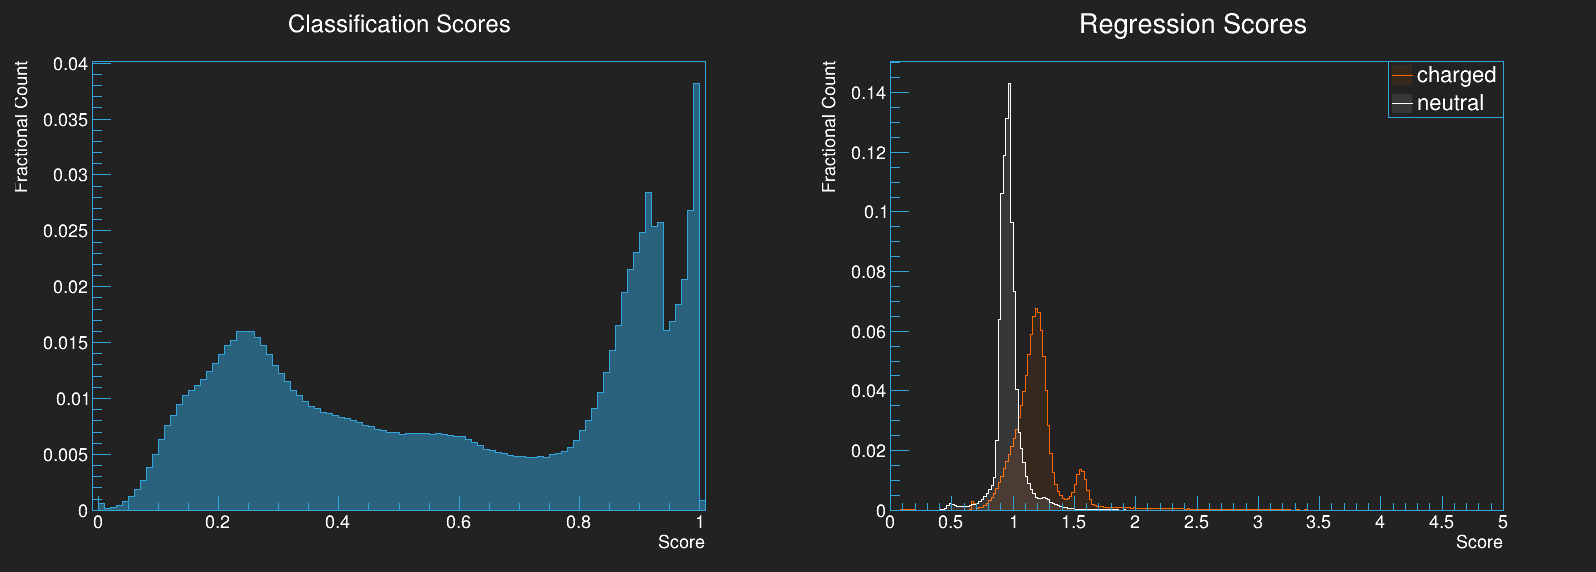

In [25]:
c = rt.TCanvas(qu.RN(),qu.RN(),1600,600)
c.Divide(2,1)

# ---
c.cd(1)
hist = rt.TH1F(qu.RN(),'Classification Scores;Score;Fractional Count',102,-0.01,1.01)
for entry in classification_scores: hist.Fill(entry)
hist.SetLineColor(ps.main)
hist.SetFillColorAlpha(ps.main, 0.5)
hist.Scale(1./hist.Integral())
hist.Draw('HIST')
# ---
c.cd(2)
stack = rt.THStack(qu.RN(),'Regression Scores;Score;Fractional Count')
leg = rt.TLegend(0.75,0.8,0.9,0.9)
h = {key:rt.TH1F(qu.RN(),'',250,0.,5.0) for key in regression_scores.keys()}
colors = [ps.curve, ps.text]

for i,key in enumerate(regression_scores.keys()):
    for entry in regression_scores[key]:
        h[key].Fill(entry)
    h[key].SetLineColor(colors[i])
    h[key].SetFillColorAlpha(colors[i],0.1)
    h[key].Scale(1./h[key].Integral())
    stack.Add(h[key])
    leg.AddEntry(h[key],key,'lf')
stack.Draw('NOSTACK HIST')
leg.SetTextColor(ps.text)
leg.Draw()
# ---

c.Draw()
c.SaveAs('scores_{}.png'.format(score_cut_string))

From the simple plots above, things look sensible. Consistent with our results in training, we see that the neutral pion regression doesn't shift the energy very much, whereas the charged regression will typically shift the energy slightly upwards. Of course, these plots include *charged pion* regression scores for clusters likely to be *neutral* pions and vice-versa, but it's nonetheless a sensible result.

## Applying the classification score cut.

At the top of the notebook, we defined our classification score cut -- we use this to determine *which* energy regression (charged or neutral) to apply to each topo-cluster. All topo-clusters with scores below this cut will be treated as neutral pions, and all topo-clusters with scores above this cut will be treated as charged pions.

In [26]:
predicted_energy_key = 'clusterE_pred'

# Funky stuff since I'm not very familiar with pandas tricks.
clusterE_pred = np.array(pdata['clusterE_pred_neutral'].to_numpy()) # make a copy
charged_idxs = (pdata[classification_key] > classification_score_cut).to_numpy()
clusterE_pred[charged_idxs] = pdata['clusterE_pred_charged'][charged_idxs].to_numpy()

pdata[predicted_energy_key] = clusterE_pred

Let's double-check the predicted topo-cluster energy distribution -- how have things shifted with respect to the old one?

We can also look at the regression scores as a function of energy.

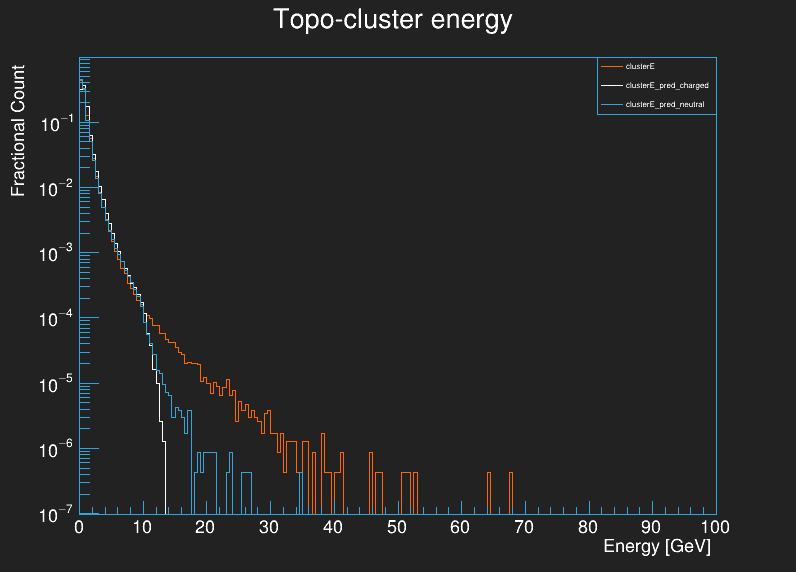

In [45]:
c = rt.TCanvas(qu.RN(),'',800,600)
hstack = rt.THStack(qu.RN(),'Topo-cluster energy;Energy [GeV]; Fractional Count')
hists = []
binning = (200,0.,100.)
colors = [ps.curve, ps.text, ps.main]
legend = rt.TLegend(0.75,0.8,0.9,0.9)
legend.SetTextColor(ps.text)

for i,key in enumerate(['clusterE','clusterE_pred_charged', 'clusterE_pred_neutral']):
    h = rt.TH1F(qu.RN(),'',*binning)
    h.SetLineColor(colors[i])
    for entry in pdata[key].to_numpy(): h.Fill(entry)
    h.Scale(1./h.Integral())
    hstack.Add(h)
    legend.AddEntry(h,key,'l')
    
hstack.Draw('NOSTACK HIST')
legend.Draw()
rt.gPad.SetLogy()
c.Draw()
c.SaveAs('regression_energies_{}.png'.format(score_cut_string))

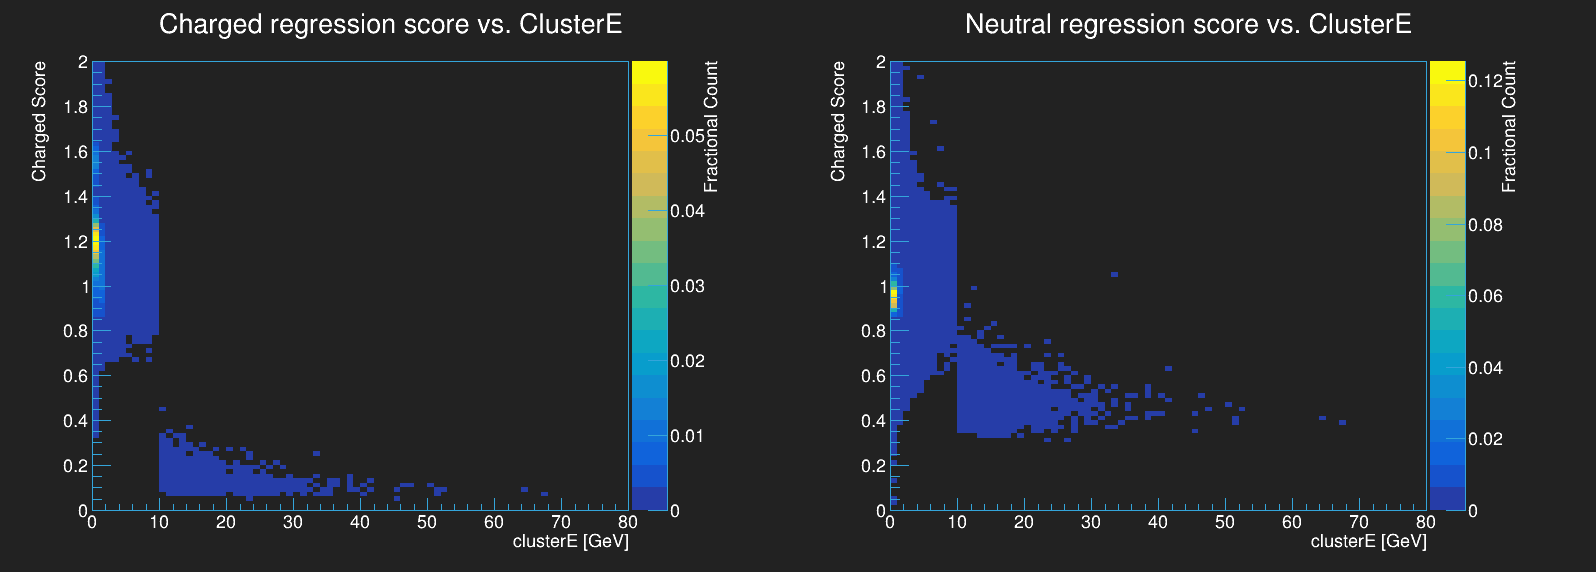

In [53]:
c = rt.TCanvas(qu.RN(),'',1600,600)
c.Divide(2,1)
binning = (80,0.,80.,100,0.,2.)
hists = []

c.cd(1)
h = rt.TH2F(qu.RN(),'Charged regression score vs. ClusterE;clusterE [GeV];Charged Score;Fractional Count', *binning)

n = len(regression_scores['charged'])
clusterE = pdata['clusterE'].to_numpy()
for i in range(n):
    h.Fill(clusterE[i], regression_scores['charged'][i])
    
h.Scale(1./h.Integral())
h.Draw('COLZ')
rt.gPad.SetRightMargin(0.2)
hists.append(h)

c.cd(2)
h = rt.TH2F(qu.RN(),'Neutral regression score vs. ClusterE;clusterE [GeV];Charged Score;Fractional Count', *binning)
n = len(regression_scores['charged'])
clusterE = pdata['clusterE'].to_numpy()
for i in range(n):
    h.Fill(clusterE[i], regression_scores['neutral'][i])
    
h.Scale(1./h.Integral())
h.Draw('COLZ')
rt.gPad.SetRightMargin(0.2)
hists.append(h)

c.Draw()
c.SaveAs('scores_vs_energy_{}.png'.format(score_cut_string))

## Jet clustering

Now we want to cluster jets from our topo-clusters, using the predicted energies.

Jet clustering is performed at the *event level*, whereas our DataFrame `pdata` contains *cluster level* information, i.e. it does not have information on which event a particular cluster belongs to. However, we can fetch this information from the `EventTree` in the ROOT files.

Specifically, each `EventTree` has a branch called `clusterCount` that gives the index of the 1st cluster in the associated `ClusterTree` that belongs to that event -- which together with `nCluster` can be used to associate a set of clusters with a given event.

The only issue is that we're opening *multiple* trees at once and chaining them together in the DataFrame (via `uproot.lazy`, which is a little like `ROOT.TChain`). The `clusterCount` variable starts at 0 for every tree, so it gives the index with respect to the current tree but not with respect to the full DataFraame. This is however relatively easy to fix.

Furthermore, we have to consider that we have thrown out topo-clusters that didn't pass certain cuts -- so we have to be careful when converting from indices in the original ROOT files (that contain all topo-clusters) to indices in our DataFrame, that contains only filtered topo-clusters.

In [26]:
def GetGlobalClusterCount(cluster_count):
    n = len(cluster_count)
    for i in range(1,n):
        if(cluster_count[i] <= cluster_count[i-1]):
            cluster_count[i:] += cluster_count[i-1]
    return cluster_count

@jit
def SelectionsToFrameIndices(sel_indices):
    new_indices = np.full(sel_indices.shape, -1, dtype=np.dtype('i8'))
    counter = 0
    for i,idx in enumerate(sel_indices):
        if(idx):
            new_indices[i] = counter
            counter += 1
    return new_indices

In [27]:
cluster_idx_branches = ['clusterCount','nCluster']


cluster_event_info = ur.lazy([':'.join((x,'EventTree')) for x in rootfiles['jet']], 
                             filter_branch=lambda x: x.name in cluster_idx_branches
                            )

cluster_event_info = {key:cluster_event_info[key].to_numpy() for key in cluster_idx_branches}
cluster_event_info['clusterCount'] = GetGlobalClusterCount(cluster_event_info['clusterCount'])
nevents = cluster_event_info['clusterCount'].shape[0]

selected_frame_indices = SelectionsToFrameIndices(sel_indices)

In [28]:
# Define our jet clustering
jet_radius = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_radius)

As we are working within some topo-cluster $\eta$ window cut, we only want to look at jets that are well within this window. The EM, LC and truth jets in our data will likely cover a larger $\eta$ range so we will want to remove these jets outside our $\eta$: Those outside the window can't be matched to our ML jets, and keeping them will make the jets' kinematic distributions look quite different.

In fact, we also want to throw out any jets *near* our $\eta$ window cut edge, as this cut might affect jet clustering of jets that are very close to the cut.

In [29]:
jet_max_eta = cluster_max_eta - jet_radius

In [30]:
# Create variables for saving information on the jets we cluster.
custom_jet_name = 'AntiKt4MLTopoJets'
custom_jet_keys = [custom_jet_name + x for x in jet_component_names]
custom_jet_info = {key:[] for key in custom_jet_keys}

# # Debugging: Also recreate the EM jets, using the raw topo-cluster info
# debug_jet_keys = ['AntiKt4EMTopoJets{}'.format(x) for x in ['Pt','Eta','Phi','E']]
# debug_jet_info = {key:[] for key in debug_jet_keys}

# Keep track of indices of events that have clusters passing cuts (some might not).
selected_event_indices = np.arange(nevents)

# Create a progress bar
prefix = 'Clustering ML jets:'
suffix = '% Complete'
length = 40
qu.printProgressBarColor (0, nevents, prefix=prefix, suffix=suffix, length=length)

# Event loop
for i in range(nevents):
        
    # Determine which clusters from pdata belong to this event.
    cluster_idx_start = cluster_event_info['clusterCount'][i]
    nCluster = cluster_event_info['nCluster'][i]
    cluster_idx_end = cluster_idx_start + nCluster # not included!
    
    cluster_indices = selected_frame_indices[cluster_idx_start:cluster_idx_end]
    cluster_indices = cluster_indices[cluster_indices >= 0]  
    
    # Check if there are no clusters passing cuts in this event -- if so, we skip it.
    if(len(cluster_indices) == 0):
        selected_event_indices[i] = -1
        qu.printProgressBarColor (i+1, nevents, prefix=prefix, suffix=suffix, length=length)
        continue
    
    # Gather the cluster components
    clusterE = pdata[predicted_energy_key][cluster_indices].to_numpy()    
    clusterE_old = pdata['clusterE'][cluster_indices].to_numpy()
    clusterPt = pdata['clusterPt'][cluster_indices].to_numpy() * clusterE / clusterE_old # adjust the clusterPt using the new energy, to keep things physical
    clusterEta = pdata['clusterEta'][cluster_indices].to_numpy()
    clusterPhi = pdata['clusterPhi'][cluster_indices].to_numpy()
        
    # Convert to Cartesian, which we need for FastJet. Returns format (px, py, pz, E).
    cartesian_vectors = ju.Polar2Cartesian(clusterPt, clusterEta, clusterPhi, clusterE)
    
    # Create PseudoJet objects.
    pseudojets = [fj.PseudoJet(*x) for x in cartesian_vectors]
    
    # Cluster PseudoJets.
    jets = jet_def(pseudojets)
    njets = len(jets)
    
    # Extract the jet 4-vector components, and put them in custom_jet_info.
    # FastJet gives phi in (0, 2π) whereas our reference jets use (-π,π), so we will shift things.
    jet_vectors = np.array([[x.pt(), x.eta(), x.phi() - np.pi, x.e()] for x in jets])
    
    for j,key in enumerate(custom_jet_info.keys()):
        custom_jet_info[key].append(jet_vectors[:,j])  
    qu.printProgressBarColor (i+1, nevents, prefix=prefix, suffix=suffix, length=length)
    
# Now keep only indices of events where we had any jets to cluster.
# (Some events may have only had topo-clusters outside of our eta window or below our minimum energy cut).
selected_event_indices = selected_event_indices[selected_event_indices >= 0]
print('Created ML jets for {:.2f}% of events. Events without ML jets may not have had topo-clusters passing our cuts.'.format(100. * len(selected_event_indices) / nevents))

Clustering ML jets: |████████████████████████████████████████| 100.0% % Complete
Created ML jets for 66.67% of events. Events without ML jets may not have had topo-clusters passing our cuts.


In [31]:
# Adjust jet_info. Writing it this way to avoid wonkiness when re-running notebook cells.
if(len(selected_event_indices) != len(jet_info)):
    jet_info = jet_info[selected_event_indices]

Let's create our filtered jet info, with only jets well within our topo-cluster eta window.

In [32]:
filtered_jet_info = {}
jet_names = reference_jet_names + [custom_jet_name]

nevents = len(jet_info)
prefix = 'Filtering jets:'
suffix = '% Complete'
length = 40
qu.printProgressBarColor (0, 4 * nevents, prefix=prefix, suffix=suffix, length=length)

for jname in jet_names:
    for jcomp in jet_component_names:
        key = jname + jcomp
        filtered_jet_info[key] = []

# First add our filtered "reference" jets (EM, LC, Truth)
for i,jname in enumerate(reference_jet_names):
    for j in range(nevents):
        eta = jet_info[jname + 'Eta'][j].to_numpy()
        sel = np.abs(eta) < jet_max_eta
        
        for jcomp in jet_component_names:
            key = jname + jcomp
            x = jet_info[key][j].to_numpy()[sel]
            filtered_jet_info[key].append(x) 
        if(j%10==0 or j==nevents-1): qu.printProgressBarColor (i * nevents + j + 1, 4 * nevents, prefix=prefix, suffix=suffix, length=length)
        
# Now add our filtered ML jets.
for i in range(nevents):
    eta = custom_jet_info[custom_jet_name + 'Eta'][i]
    sel = np.abs(eta) < jet_max_eta
    
    for jcomp in jet_component_names:
        key = custom_jet_name + jcomp
        x = custom_jet_info[key][i][sel]
        filtered_jet_info[key].append(x)
    if(i%10==0 or i==nevents-1): qu.printProgressBarColor (3 * nevents + i + 1, 4 * nevents, prefix=prefix, suffix=suffix, length=length)

Filtering jets: |████████████████████████████████████████| 100.0% % Complete


Note that our reference jets (EM, LC, Truth) have their transverse momentum and energy stored in MeV, whereas our ML jets have these variables stored in GeV.

To keep everything internally consistent, we will convert our reference jets to GeV.

In [33]:
for jname in reference_jet_names:
    
    for comp_name in ['Pt','E']:
        assert(comp_name in jet_component_names) # safety check in case someone changes component names
        key = jname + comp_name
        for i in range(len(filtered_jet_info[key])):
            filtered_jet_info[key][i] /= 1000.    

## Some initial jet plotting

At this point, we've created our ML jets. We still haven't performed any jet matching, but let's take a glance at some distributions.

In [34]:
colors = [rt.kGreen, rt.kViolet-4, rt.kRed, ps.curve]

In [35]:
# Create a TPaveText with cuts.

cut_text = [
    '|#eta_{jet}|' + ' < {:.1f}'.format(jet_max_eta),
    '|#eta_{cluster}|' + ' < {:.1f}'.format(cluster_max_eta)
]

cut_box = rt.TPaveText(0.7,0.5,0.9,0.75, 'NDC')
cut_box.SetTextColor(ps.text)
cut_box.SetBorderSize(1)
cut_box.SetFillColorAlpha(ps.canv,0.5)
cut_box.SetTextSize(3e-2)


for text in cut_text:
    cut_box.AddText(text)

Info in <TCanvas::Print>: png file jet_kin.png has been created


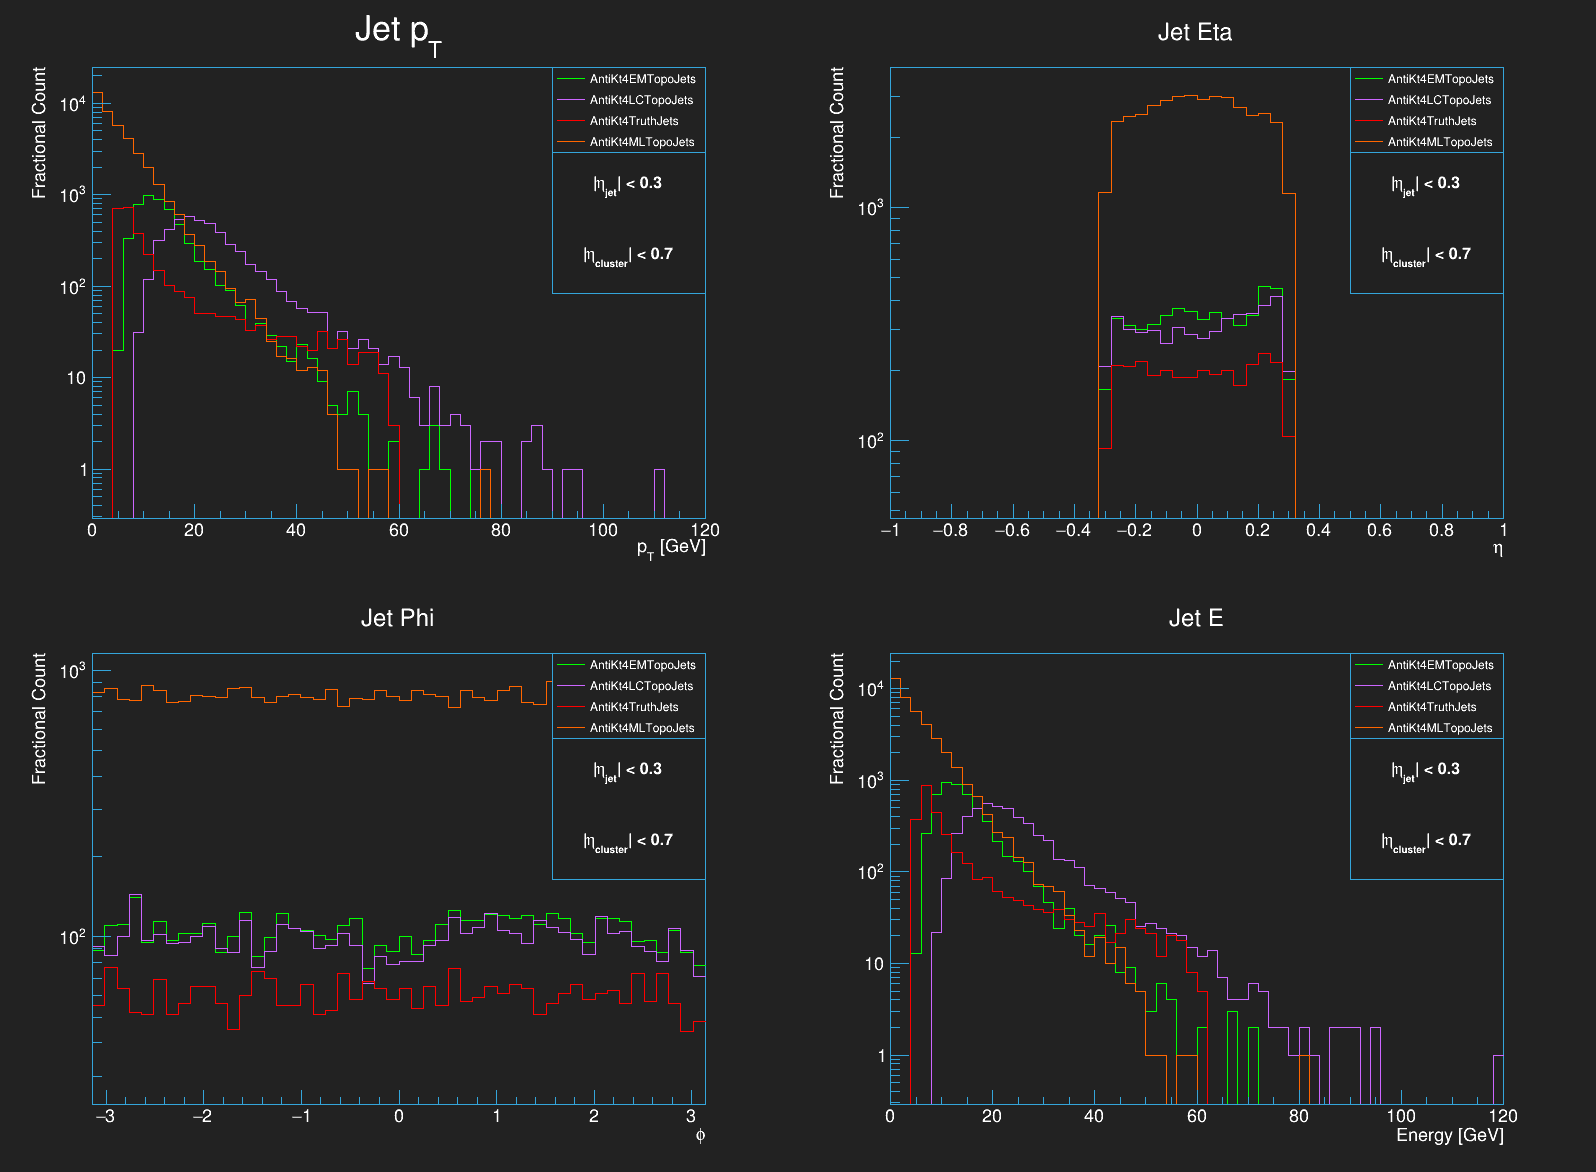

In [36]:
c = rt.TCanvas(qu.RN(),'',1600,1200)
hists = []
stacks = []
c.Divide(2,2)

c.cd(1)
leg = rt.TLegend(0.7,0.75,0.9,0.9)
leg.SetTextColor(ps.text)
hstack = rt.THStack(qu.RN(),'Jet p_{T};p_{T} [GeV];Fractional Count')

for i,jname in enumerate(jet_names):
    
    x = np.concatenate(filtered_jet_info[jname + 'Pt'])
    h = rt.TH1F(qu.RN(),'',60,0.,120.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    leg.AddEntry(h,jname,'l')
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.cd(2)
hstack = rt.THStack(qu.RN(),'Jet Eta;#eta;Fractional Count')
for i,jname in enumerate(jet_names):
    
    x = np.concatenate(filtered_jet_info[jname + 'Eta'])
    h = rt.TH1F(qu.RN(),'',50,-1.,1.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.cd(3)
hstack = rt.THStack(qu.RN(),'Jet Phi;#phi;Fractional Count')
for i,jname in enumerate(jet_names):
    
    x = np.concatenate(filtered_jet_info[jname + 'Phi'])
    h = rt.TH1F(qu.RN(),'',50, -np.pi, np.pi)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.cd(4)
hstack = rt.THStack(qu.RN(),'Jet E;Energy [GeV];Fractional Count')
for i,jname in enumerate(jet_names):
    
    x = np.concatenate(filtered_jet_info[jname + 'E'])
    h = rt.TH1F(qu.RN(),'',60,0.,120.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.Draw()
c.SaveAs('jet_kin_{}.png'.format(score_cut_string))

Right off the bat, we see that there are way more ML jets than other varieties. That's not a problem, as we haven't applied *any* sort of cuts to our ML jets. We alternatively could have plotted fractional counts, but that could also be misleading -- here at least we know that the final distributions for ML jets will be something carved out of what we see here.

## Jet Matching

Now, we have to perform jet matching, specifically:
- Match `AntiKt4EMTopoJets` to `AntiKt4TruthJets`
- Match `AntiKt4LCTopoJets` to `AntiKt4TruthJets`
- Match `AntiKt4MLTopoJets` to `AntiKt4TruthJets`

Once we have matched jets, we can compute the jet energy response.

To perform matching, we will use some (slightly modified) code from the [GepJetMatching package](https://gitlab.cern.ch/jaofferm/gepjetmatching). This already implements the ATLAS jet matching algorithm so we don't have to re-invent the wheel. The only issue is that we will have to save our current jets to a ROOT file (with a somewhat particular format) and its output will also be a ROOT file.

In [37]:
if(os.getcwd() not in sys.path): sys.path.append(os.getcwd())
from jet_util import jet_matching as jm

In [38]:
# Saving our jets to a file.
jet_file = 'jets_{}.root'.format(score_cut_string)
tree_name = 'ntuple' # name must be "ntuple", this is used internally by GepJetMatching
f = rt.TFile(jet_file,'RECREATE')
t = rt.TTree(tree_name,tree_name) 

branches = {}
buffers = {}
for key in filtered_jet_info.keys():
    buffers[key] = rt.std.vector('double')()
    branches[key] = t.Branch(key,buffers[key])
    
nevents = len(jet_info) # redundant, just for safety
for i in range(nevents):  
    for buffer in buffers.values(): buffer.clear()
    for key,vals in filtered_jet_info.items():
        for val in vals[i]: buffers[key].push_back(val)      
    t.Fill()
t.Write()
f.Close()

In [39]:
# Now we want to match each reco jet (EM, LC, ML) to truth.
match_settings = {
    'pt_min':7.0, # here in GeV
    'eta_max':4.5,
    'requirePileupCheck':False, # TODO: turn on if we have pileup
    'requireIsoReco':True,
    'requireIsoTruth':True,
    'dr':0.3,
    'truth_iso_dr':0.3,
    'reco_iso_dr':0.3
}

reco_jets = [x for x in jet_names if 'Truth' not in x]
truth_jet = 'AntiKt4TruthJets'
matches = ['{}->{}'.format(x,truth_jet) for x in reco_jets]
matched_jet_files = {
    key: '{}_{}.root'.format(key,score_cut_string)
    for key in reco_jets
}

In [40]:
executable_suffix = 'jet_util/' # relative location of JetMatching.C, our ROOT C++ macro for jet matching
for i,reco_jet in enumerate(reco_jets):
    print('Matching {}.'.format(matches[i]))
    jm.MatchJets(matches[i], match_settings, [jet_file], matched_jet_files[reco_jet],executable_suffix)

# Delete files created by our jet matching macro compilation
jet_compilation_files = []
for extension in ['d','pcm']:
    jet_compilation_files += glob.glob(os.getcwd() + '/' + executable_suffix + '*.{}'.format(extension))
for file in jet_compilation_files:
    command = ['rm', file]
    sub.check_call(command)

Matching AntiKt4EMTopoJets->AntiKt4TruthJets.
Matching AntiKt4LCTopoJets->AntiKt4TruthJets.
Matching AntiKt4MLTopoJets->AntiKt4TruthJets.


Now that we have ROOT files containing matched jets, let's open them with `uproot`. With these, we can easily compute the energy response. We'll also plot the kinematics of our matched jets.

In [41]:
matched_jet_trees = {
    key:ur.open(val)[tree_name]
    for key,val in matched_jet_files.items()
}

In [42]:
colors = [rt.kGreen, rt.kViolet-4, ps.curve]

Info in <TCanvas::Print>: png file jet_kin_matched.png has been created


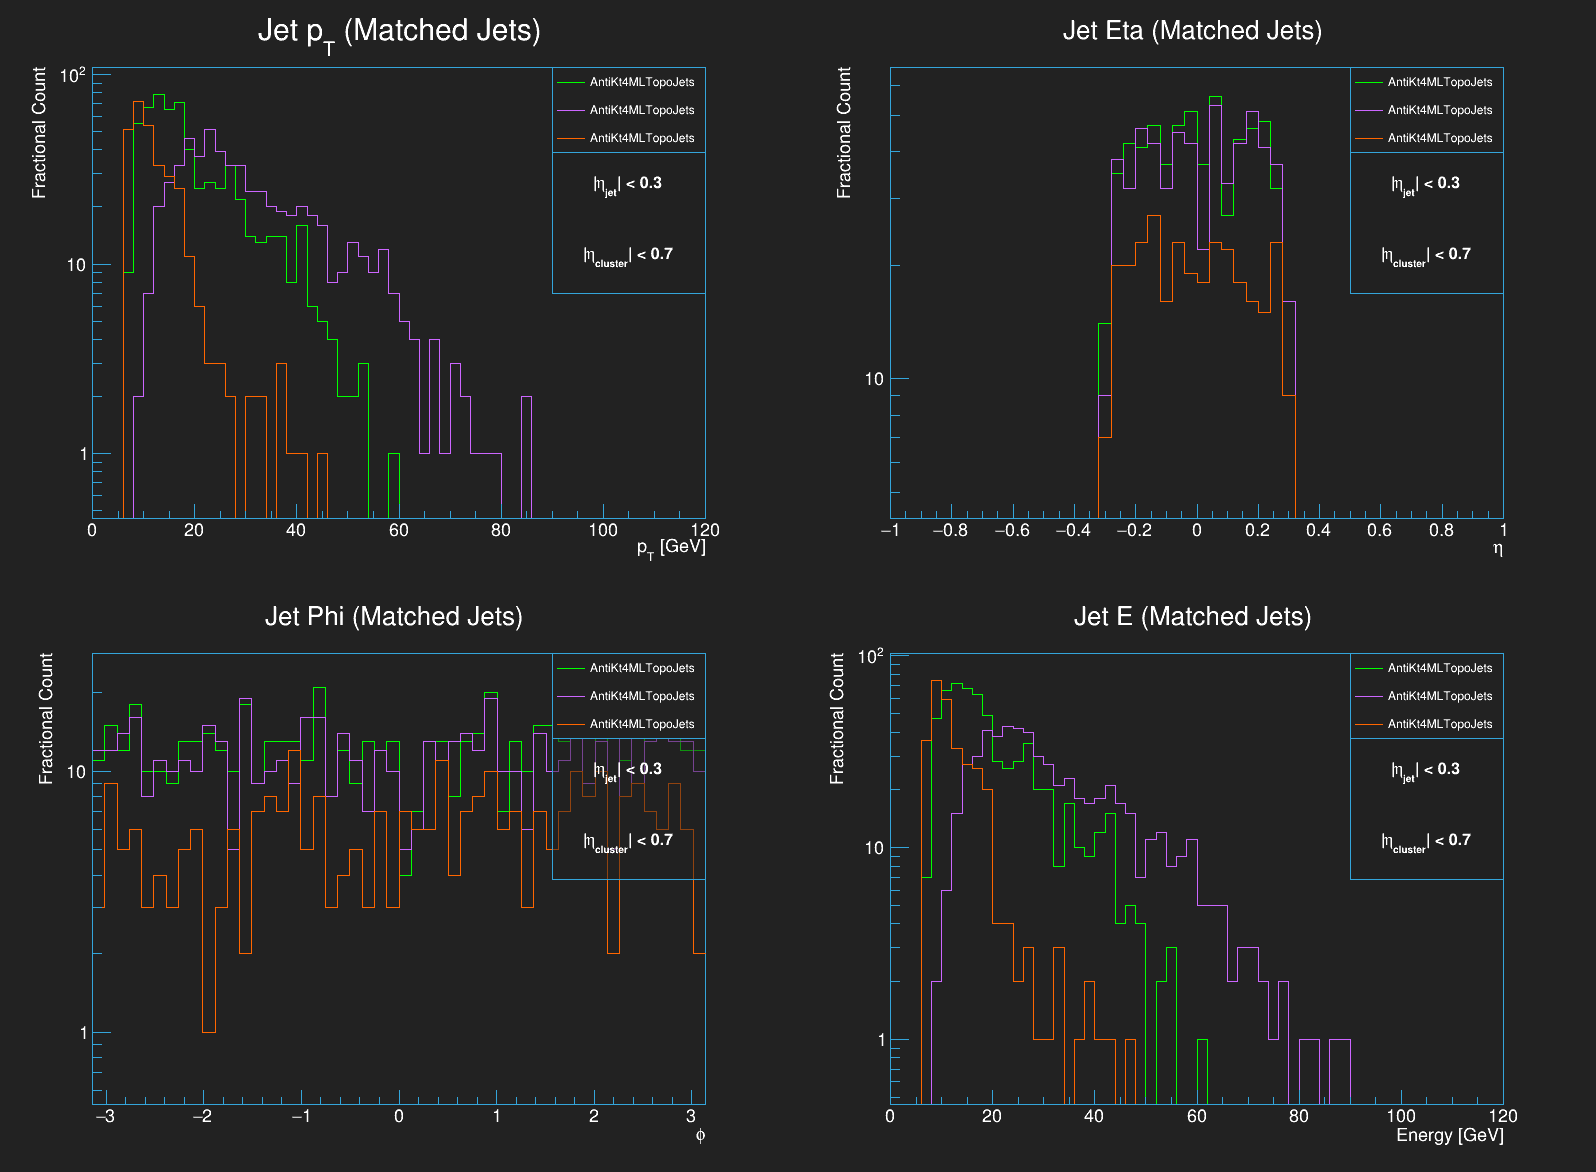

In [48]:
c = rt.TCanvas(qu.RN(),'',1600,1200)
hists = []
stacks = []
c.Divide(2,2)

c.cd(1)
leg = rt.TLegend(0.7,0.75,0.9,0.9)
leg.SetTextColor(ps.text)
hstack = rt.THStack(qu.RN(),'Jet p_{T} (Matched Jets);p_{T} [GeV];Fractional Count')

for i,reco_jet in enumerate(reco_jets):
    x = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'Pt'].array()).to_numpy()
    h = rt.TH1F(qu.RN(),'',60,0.,120.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    leg.AddEntry(h,jname,'l')
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.Draw()

c.cd(2)
hstack = rt.THStack(qu.RN(),'Jet Eta (Matched Jets);#eta;Fractional Count')
for i,reco_jet in enumerate(reco_jets):
    x = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'Eta'].array()).to_numpy()
    h = rt.TH1F(qu.RN(),'',50,-1.,1.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.cd(3)
hstack = rt.THStack(qu.RN(),'Jet Phi (Matched Jets);#phi;Fractional Count')
for i,reco_jet in enumerate(reco_jets):
    x = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'Phi'].array()).to_numpy()
    h = rt.TH1F(qu.RN(),'',50, -np.pi, np.pi)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.cd(4)
hstack = rt.THStack(qu.RN(),'Jet E (Matched Jets);Energy [GeV];Fractional Count')
for i,reco_jet in enumerate(reco_jets):
    x = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'E'].array()).to_numpy()
    h = rt.TH1F(qu.RN(),'',60,0.,120.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.Draw()
c.SaveAs('jet_kin_matched_{}.png'.format(score_cut_string))

In [49]:
energy_response = {}

In [50]:
for reco_jet in reco_jets:
    reco_energy = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'E'].array()).to_numpy()
    truth_energy = ak.flatten(matched_jet_trees[reco_jet][truth_jet + 'E'].array()).to_numpy()
    energy_response[reco_jet] = reco_energy / truth_energy
    print(reco_jet, len(reco_energy))

AntiKt4EMTopoJets 619
AntiKt4LCTopoJets 581
AntiKt4MLTopoJets 299


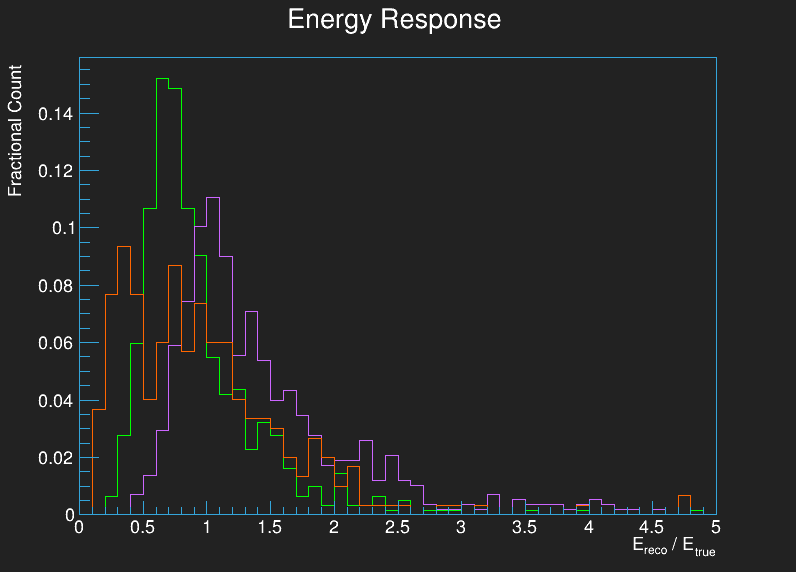

In [54]:
c = rt.TCanvas(qu.RN(), 'c', 800, 600)
hstack = rt.THStack(qu.RN(),'Energy Response;E_{reco} / E_{true};Fractional Count')
binning = (50,0.,5.)
for i,reco_jet in enumerate(reco_jets):
    h = rt.TH1F(qu.RN(),'',*binning)
    for entry in energy_response[reco_jet]: h.Fill(entry)
    h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hists.append(h)
    hstack.Add(h)
hstack.Draw('NOSTACK HIST')
c.Draw()
c.SaveAs('response_{}.png'.format(score_cut_string))

In [ ]:
# if __name__ == '__main__':
#     main(sys.argv)